# Bilayer Sonophore model: analysis of static pressure forces

### Imports

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

from PySONIC.core import BilayerSonophore, PmCompMethod

### Parameters

In [2]:
a = 32e-9  # in-plane radius (m)
Cm0 = 1e-2  # membrane resting capacitance (F/m2)
Qm0 = -71.9e-5  # membrane resting charge density (C/m2)
bls = BilayerSonophore(a, Cm0, Qm0)
Z = np.linspace(-0.45 * bls.Delta, 2 * bls.a, 3000)

### Functions

In [3]:
def prepareAxis(ax, xlabel, fs):
    if xlabel == 'Leaflet deflection (nm)':
        ax.set_xticks([-0.5 * bls.Delta * 1e9, bls.a * 1e9])
        ax.set_xticklabels(['$-\Delta / 2$', 'a'])
        ax.axvline(-0.5 * bls.Delta * 1e9, linestyle='--', color='dimgrey')
        ax.axvline(bls.a * 1e9, linestyle='--', color='dimgrey')
        ax.yaxis.set_major_locator(ticker.MaxNLocator(2))
        ax.axhline(0.0, color='k', linewidth=1)
    else:
        ax.set_yticks([-0.5 * bls.Delta * 1e9, 0])
        ax.set_yticklabels(['$-\Delta / 2$', '0'])
        ax.axhline(-0.5 * bls.Delta * 1e9, linestyle='--', color='dimgrey')
        ax.axhline(0, linestyle='--', color='dimgrey')
        ax.xaxis.set_major_locator(ticker.MaxNLocator(2))
        ax.axvline(0.0, color='k', linewidth=1)
    ax.set_xlabel(xlabel, fontsize=fs)
    for key in ['top', 'right']:
        ax.spines[key].set_visible(False)
            

def plotVars(yvars, labels, limits=None, sharex=False, unit=None, xvar=Z * 1e9, xlabel='Leaflet deflection (nm)', fs=12, lw=2):
    if not sharex:
        naxes = len(yvars)
        fig, axes = plt.subplots(1, naxes, figsize=(5 * naxes, 3))
        if naxes == 1:
            axes = [axes]
        for i, ax, in enumerate(axes):
            prepareAxis(ax, xlabel, fs)
            ax.set_ylabel(labels[i], fontsize=fs)
            ax.plot(xvar, yvars[i], linewidth=lw)
            if limits is not None:
                ax.set_ylim(limits[i])
    else:
        naxes = len(yvars)
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
        prepareAxis(ax, xlabel, fs)
        ax.set_ylabel(unit, fontsize=fs)
        for yvar, label in zip(yvars, labels):
            ax.plot(xvar, yvar, linewidth=lw, label=label)
        if limits is not None:
            ax.set_ylim(limits)
        ax.legend(fontsize=fs, loc='center right', bbox_to_anchor=(1.5, 0.5), frameon=False)
    fig.tight_layout()
    return fig

### Geometrical variables

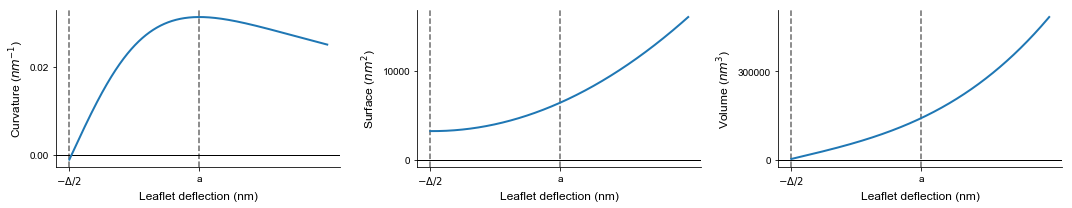

In [4]:
R = bls.v_curvrad(Z)
S = bls.surface(Z)
V = bls.volume(Z)

fig = plotVars(
    [1 / R * 1e-9, S * 1e18, V * 1e27],
    ['Curvature ($nm^{-1}$)', 'Surface ($nm^2$)', 'Volume ($nm^3$)']
)

- The **leaflet curvature** is negative for a compressed sonophore (Z < 0) and positive for a expanded sonophore (Z > 0). It reaches a maximum when the deflection equals the in-plane diameter of the sonophore
- The **leaflet surface** and **sonophore volume** both increase with the deflection magnitude. Note that the relative surface increases is less pronounced than the relative volume increase

### Intermolecular pressure

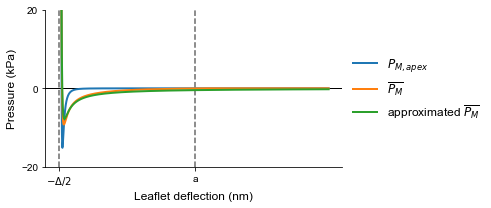

In [5]:
Pm_apex = np.array([bls.PMlocal(0.0, z, r) for z, r in zip(Z, R)])
Pm_avg = bls.v_PMavg(Z, R, S)
Pm_avg_predict = bls.PMavgpred(Z)

fig = plotVars(
    [Pm_apex * 1e-3, Pm_avg * 1e-3, Pm_avg_predict * 1e-3],
    ['$P_{M, apex}$', '$\overline{P_{M}}$', 'approximated $\overline{P_{M}}$'],
    limits=(-20, 20),
    sharex=True,
    unit='Pressure (kPa)'
)

- The **intermolecular pressure at the leaflet apex** follows a marked *Lennard-Jones* profile
- The **average leaflet intermolecular pressure** profile is similar in nature but less marked than that of the apex pressure
- The ***Lennard-Jones* approximation of the average leaflet intermolecular pressure** is quite accurate

### Electrical pressure

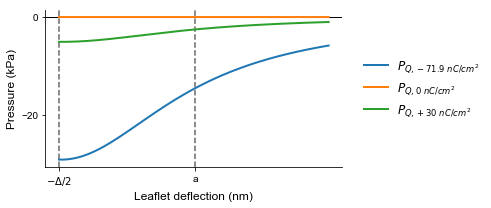

In [6]:
PQ_Qm0 = bls.Pelec(Z, bls.Qm0)
PQ_0 = bls.Pelec(Z, 0)
PQ_AP = bls.Pelec(Z, 30.0e-5)

fig = plotVars(
    [PQ_Qm0 * 1e-3, PQ_0 * 1e-3, PQ_AP * 1e-3],
    ['$P_{Q, -71.9\ nC/cm^2}$', '$P_{Q, 0\ nC/cm^2}$', '$P_{Q, +30\ nC/cm^2}$'],
    sharex=True,
    unit='Pressure (kPa)'
)

**Electrical pressure** is null when the membrane is not charged, and then increases in magnitude with the square of charge density and decreases as the inter-leaflet distance increases

### Gas pressure

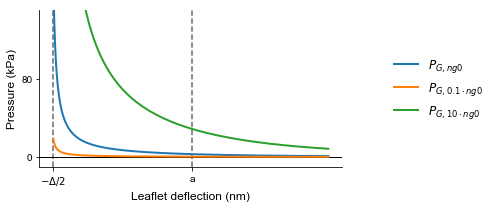

In [7]:
Pg_ng0 = bls.gasmol2Pa(bls.ng0, V)
Pg_sparse = bls.gasmol2Pa(0.1 * bls.ng0, V)
Pg_dense = bls.gasmol2Pa(10 * bls.ng0, V)

fig = plotVars(
    np.array([Pg_ng0, Pg_sparse, Pg_dense]) * 1e-3,
    ['$P_{G, ng0}$', '$P_{G, 0.1 \cdot ng0}$', '$P_{G, 10 \cdot ng0}$'],
    sharex=True,
    unit='Pressure (kPa)',
    limits=(-10, 150)
)

In th absence of gas transport, **gas pressure** increases here when the sonophore is compressed. However, in reality gas transport keeps the pressure around $P_0$.

### Elastic tension pressure

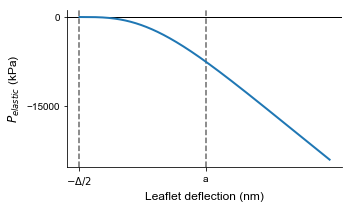

In [8]:
Pel = bls.PEtot(Z, R)
fig = plotVars(
    np.array([Pel]) * 1e-3,
    ['$P_{elastic}$ (kPa)']
)

**Elastic tension pressure** increases with the relative stretch of the sonpophore leaflets. Therefore, it is null at Z = 0 and increases during both sonophore compressions and expansions. Its effect is very limited during compressions, however it becomes quite significant during expansions phases.

### Pressure balance

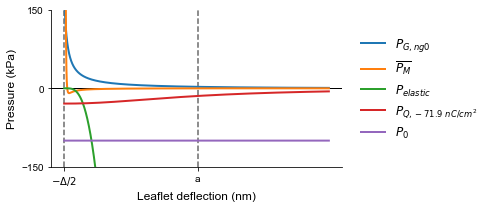

In [9]:
P0 = np.ones(len(Z)) * bls.P0

fig = plotVars(
    np.array([Pg_ng0, Pm_avg, Pel, PQ_Qm0, -P0]) * 1e-3,
    ['$P_{G, ng0}$', '$\overline{P_{M}}$', '$P_{elastic}$', '$P_{Q, -71.9\ nC/cm^2}$', '$P_0$'],
    limits=(-150, 150),
    sharex=True,
    unit='Pressure (kPa)'
)

As expected, the **intermolecular pressure dominates during compressions**, while the **elastic tension pressure dominates for siginficant expansions**. **In between, the static and gas pressure dominate** together.

### Balance quasi-steady deflection

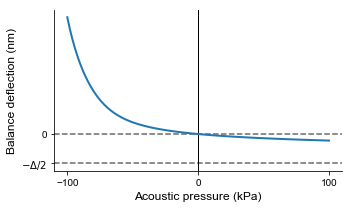

In [10]:
Pac = np.linspace(-1e5, 1e5, 100)
Zqs = np.array([bls.balancedefQS(bls.ng0, bls.Qm0, pac, PmCompMethod.direct) for pac in Pac])

fig = plotVars(
    [Zqs * 1e9],
    ['Balance deflection (nm)'],
    xvar=Pac * 1e-3,
    xlabel='Acoustic pressure (kPa)'
)

As expected, a negative acoustic pressure drives the quasi-steady system towards a positive deflection, whereas a positive acoustic pressure drives the system towards comprression.